# Surface code compilation

Semester project: _A practical introduction into surface code compilation_ at
[LSI](https://www.epfl.ch/labs/lsi/), EPFL.

Professor: Prof. [Giovanni De
Micheli](https://people.epfl.ch/giovanni.demicheli/?lang=en)\
Supervisor: [Mathias Soeken](https://people.epfl.ch/mathias.soeken?lang=en),
Ph.D.\
Student: [Nicolas Bähler](https://people.epfl.ch/nicolas.bahler?lang=en)

I'd like to thank my supervisor, Mathias, for his help and guidance during the project

## Table of contents

- [Introduction](#introduction)
- [Theory](#theory)
  - [Surface codes](#surface-codes)
    - [Logical qubit](#logical-qubit)
    - [Elementary surface code operations](#elementary-surface-code-operations)
  - [Universality of the gate set](#universality-of-the-gate-set)
  - [Compilation of long-range CNOTs](#compilation-of-long-range-cnots)
- [Practical implementation](#practical-implementation)
  - [Scheduling](#scheduling)
  - [Compilation](#compilation)
- [Correctness](#correctness)
- [Further steps](#further-steps)
- [Further optimizations](#further-optimizations)
- [Conclusion](#conclusion)
- [Appendix](#appendix)
  - [Operations](#operations)
    - [Bell preparation](#bell-preparation)
    - [Long-range Bell preparation](#long-range-bell-preparation)
    - [Bell measurement](#bell-measurement)
    - [Hadamard](#hadamard)
    - [CNOT](#cnot)
    - [Long-range CNOT](#long-range-cnot)
    - [Move](#move)
    - [Swap](#swap)
- [References](#references)

## [Introduction](#introduction)

The semester project is mainly based on [this
paper](https://arxiv.org/pdf/2110.11493.pdf) [\[1\]](#references). First, it
introduces surface codes as a means to implement fault-tolerant quantum
computing. Upon this basis, the authors propose a compilation scheme for quantum
circuits taking into account the geometrical constraints of todays hardware and
the surface code itself. Further, the novel technique allows to compile
significant parts of the circuit in a parallel fashion, which is a huge
advantage over naive compilation for surface codes.

This notebook will follow the structure of the paper and first introduce the
basics of surface codes and explain the compilation scheme in a
theoretical manner before presenting important aspects of an implementation of the proposed
compilation scheme.


## [Theory](#theory)

### [Surface codes](#surface-codes)

Surface codes, a special kind of Error Correcting Codes (ECCs), hold the promise
to make fault-tolerant and large-scale quantum computing possible. No physical
device is perfect and hence there is always a certain error rate for each
device. ECCs are an attempt to detect errors, generally by adding some sort of
redundancy to the information that might get degraded by an error occurring in
the device, and then correct them to ensure correctness despite the errors.

In the realm of quantum computing one needs to be specifically ingenious because
the detection of errors requires performing measurements which, generally
speaking, collapses the quantum state and hence can destroy information.

#### [Logical qubit](#logical-qubit)

The basic idea behind surface codes is simple. Assume a planar grid of qubits
and only neighbor interactions between qubits are possible. As a matter of fact,
this setup is particularly interesting as it matches todays hardware. Square
patches of _physical_ qubits, are conceptually combined into one _logical_ qubit
in a way that makes this logical qubit error correctable.

![alt text](figures/logical_qubit.png)\
_A patch of physical qubits that are used to encode in a fault-tolerant manner a
single logical qubit. [\[1\]](#references)_

The physical qubits inside a patch are split up into data qubits (black dots in
the figure above) and ancilla qubits (white dots in the figure above). Through a
set of smart measurements of the ancilla qubits only, one can infer errors that
might have occurred on the data qubits, which can then be corrected such that
the majority of the data qubits hold the correct value. In this way one can
correct a number of errors, generally referred to as the _code distance_. In the
above example, the code distance is $d=5$.

The squares having the colors either blue or red, called _plaquettes_,
as a composed system of qubits allow to detect and correct X- and Z-type errors,
respectively. With going into more detail, let's move up a level in the stack of
abstractions and discuss the elementary operations that can be performed on the
basis of the logical qubits.

#### [Elementary surface code operations](#elementary-surface-code-operations)

![alt text](figures/operations.png)\
_Elementary surface code operations: Single-qubit preparation in the X basis
(i), and the Z basis (ii), destructive single-qubit measurement, in the X basis
(iii), and the Z basis (iv), two-qubit joint measurement of XX (v) and ZZ (vi),
a move of a logical qubit from one patch to an unused patch (vii), two-qubit
preparation (viii) and destructive measurement (ix) in the Bell basis, and
finally a Hadamard gate using 3 ancilla logical qubits (x).
[\[1\]](#references)_

For anyone familiar with the _Quantum Circuit Model_, this colorful picture above
seems very different from conventional quantum circuits. Each cell of the gray
chessboard represents one logical qubit. On
top of that fault-tolerant structure, one can build a set of elementary gates
which are depicted in the figure above. By composing multiple elementary gates,
the gate set can be extended to be universal, in the sense that any unitary can
be approximated arbitrarily closely.

In the [appendix](#appendix) of this notebook, the different
[operations](#operations) are listed for completeness.

### [Universality of the gate set](#universality-of-the-gate-set)

The goal is to implement preparations and measurements of individual qubits in the
computational basis (Z basis), controlled-not (CNOT), Pauli-X, -Y, and -Z,
Hadamard (H), Phase S and T gates. This is a universal set of gates, in then
sense eluded to above.

The set of elementary surface code operations allows to directly implement all
but the Pauli and phase gates. As Pauli gates commute with the remaining gates of this very gate set,
they can be tracked classically and then the final measurements adapted accordingly.
Hence, there is no need to implement those physically. In order to also implement the
phase gates, a technique named _Magic State Distillation_ can be employed.

This technique uses highly specialized circuit sections, called _Magic State
Factories_, which can be in a region of the 2D grid of logical qubits far apart
from the main section where the quantum algorithm is implemented. In those
factories, initial low quality quantum states are repeatedly processed to
improve their quality until the resulting state is close enough to a target
state, hence the term _distillation_. Consuming such magic states, both phase
gates (S and T) can be fabricated. For S and T gates to be useable in the
quantum circuit that implements the unitary in question, though, there is still
a major challenge: How can those magic states be _transported_ from their factories
(potentially in a far away region of the
grid) to the location where they are needed to implement either of the phase gates?

This problem is closely related to another aspect of the surface code
architecture. As opposed to conventional quantum circuits, geometrical
constraints are taken into account in this scheme. Normally, the complexity of
physically computing a 2-operands gate on two distant qubits is completely
abstracted away. With surface code architectures, which are closer to the
underlying hardware and take geometric constraints into account, one does not
have the luxury to forget about the geometrical aspect of the problem.

The simplest idea to move quantum states around on the grid is to use a bunch of
Swap gates (can be easily implemented using two move operations, [Swap](#swap))
to bring the two quantum states, the operands of the two-qubit
operation, physically close
together. But there is a catch, this requires
$Ω(k)$ Swap gates, where $k$ is the distance between the operands.

![alt text](figures/swap_cnot.png)\
_Illustration of how Swap gates can be used to transport the quantum state
closer together such that a CNOT can be performed. [\[1\]](#references)_

Is there a more efficient way of doing it? The answer is yes, but it
comes at the cost of some added compilation complexity! This is best understood
by going through a concrete example, here the compilation of
long-range CNOTs, meaning CNOTs between physically distant qubits.

### [Compilation of long-range CNOTs](#compilation-of-long-range-cnots)

First, let’s look at how a CNOT can be expressed in terms of elementary
operations.

![alt text](figures/cnot.png)\
_The arrow (at a for example) indicates that the result of a measurement is
stored classically in a variable, which can then be used to conditionally
perform additional operations if the variable equals $|1\rangle$, indicated by
the equal sign (at b for example). The CNOT additionally consumes a $|+\rangle$
state. [\[1\]](#references)_

The key idea, to extend this circuitry to support long-range without using Swap
gates, is to entangle the operands using long-range Bell preparation.

![alt text](figures/long_range_bell_prep.png)\
_Bell preparation that allows to transport quantum states in constant depth.
[\[1\]](#references)_

Put together, one gets the following implementation of the long-range CNOT:

![alt text](figures/long_range_cnot.png)\
_An implementation of a long-range CNOT using Bell preparation.
[\[1\]](#references)_

Note the constant depth of the circuit, although $|s\rangle$ and
$|t\rangle$ can be far apart! But those entangled chains add geometrical
complexity. On the 2D grid structure of logical qubits, the Bell
preparations can be seen as paths from target to control qubits. Additionally,
the aim is to execute as much of such operations in parallel to further improve
the performance. But hence, intersections with other Bell preparations must be
avoided to maintain correctness.

To make it easier to avoid such overlaps, one can
subdivide the 2D grid of logical qubits into
data and ancilla qubits. CNOTs can only be performed on data qubits, where the
ancillas are going to host the Bell chains between the control and the target
qubit, also referred to as _terminals_. Further, one can define a graph structure,
called _Operator Graph_, highlight in blue below, which shows all the possible
paths between different terminal pairs.

![alt text](figures/operator_paths.png)\
_Black squares are data qubits, the other ones are ancilla qubits. Further,
control data qubits (B4 for example) are only vertically connected to its
neighboring ancillas, similarly target data qubits (D2 for example) are only
adjacent to their neighbors vertically. These limitations are due to the nature
of the underling surface code. [\[1\]](#references)_

With this graph in mind, having non overlapping Bell preparations is equal to
computing vertex-disjoint paths from control to target qubits.

The same idea of using such Bell chains can be applied to transporting the
aforementioned magic states from their factories to the location on the grid
where we need to implement phase gates, thus, also at constant depth.

Let’s look at some aspects of the compilation process in more detail by going
through a concrete example.


## [Practical implementation](#practical-implementation)

Compilation of CNOTs in itself can be divided into several steps:

1. (Define the input circuit)
2. (Compile input circuit the QIR ([Quantum Intermediate Representation](https://learn.microsoft.com/en-us/azure/quantum/concepts-qir)))
3. Read input circuit from QIR
4. Choose a mapping of qubits
5. Schedule the different operations
6. (Visualize the scheduling)
7. Compile the scheduling of operations into QIR

Step 1. and 2. are optional and implemented using the
[PyQIR](https://github.com/qir-alliance/pyqir), which is a Python library that,
amongst other features, allows to define quantum circuits and compile them into
QIR code. Note that the input QIR to step 3. can be any QIR program and must not be
generated in steps 1. and 2, which makes them optional. Additionally, one could
have picked a different input format, but QIR is a good choice, as it allows to
simulate the input circuit before the compilation and compare with the
simulation results of the compiled circuit, but more on that later.

Step 3. is also straightforward, as PyQIR also contains tools to efficiently
parse the QIR code generated earlier.

Step 4. is a necessary step from the transition of geometry agnostic
quantum circuit model to the surface code architecture. This step maps qubits onto
the 2D grid of qubits. It is not really addressed in the paper itself.

Step 5. is the core of the compilation process and the paper.

Step 6. is optional, but it can be useful to visualize the scheduling.

Step 7. is the final step, which compiles the scheduling into QIR code.

In the next section, step 5. is explained in more detail. It is the most
important and interesting part of the compilation process. Further, some aspects
of the final step, the actual compilation of the scheduling into QIR code, will
be presented.

### [Scheduling](#scheduling)

Let’s look at a concrete example to see how the compilation works in practice.
Here 5 CNOTs (control, target) to be compiled:

1. ((H, 4), (B, 2))
2. ((B, 8), (B, 4))
3. ((F, 2), (D, 2))
4. ((B, 6), (F, 4))
5. ((F, 8), (F, 6))

The coordinates reference the 2D grid of logical qubits:

![alt text](figures/grid_cnots.png)\
_Set of terminal pairs, the control and target qubits of the 5 CNOTs._

Before the compilation can start, some setup is required and imports are
required. Note that only part of the code base will be shown here, the rest will
be imported to avoid cluttering the notebook.


In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

sys.path.insert(1, os.path.abspath(".."))

import tempfile
import numpy as np
from pyqir import BasicQisBuilder, SimpleModule
from abc import ABC, abstractmethod

from operator_graph import OperatorGraph
from path import DirectKeyPath, PaperKeyPath, Path, PathType
from compiler import Compiler
from helpers import append_dump_machine, flatten, unflatten
from mapper import Identity, PaperIdentity, PaperRenaming, Renaming
from qir_parser import parse_qir
from scheduler import Scheduler, assign_color_ids, Sequential
from visualizer import Visualizer

The main algorithm combines a novel technique with a
know greedy algorithm and finally picks the result from the one that produces
fewer epochs. $\mathcal{T}$ is the set of terminals, the control and target qubits
of all the cnots and the $\mathcal{T}$-operator set is basically a valid
scheduling, i.e. a set of paths that can be executed in parallel and will when
combined together results in the CNOTs. EDP and VDP stands for edge- &
vertex-disjoint paths, respectively.

![alt text](figures/algo_3_2.png)\
_Top-level algorithm of the scheduling. [\[1\]](#references)_


In [2]:
# Scheduler that is based on the paper
class EDPC(Scheduler):
    def schedule(self):
        # First approach, using the paper's novel algorithm, compute the
        # operator EDP sets
        operator_edp_sets = self.__compute_operator_edp_sets()

        # Assign color IDs to the paths
        assign_color_ids(operator_edp_sets)

        # Split operator EDP sets into operator VDP sets
        q1 = []
        for operator_edp_set in operator_edp_sets:
            p1, p2 = self.__edp_subroutine(operator_edp_set)

            q1.append(p1)

            # Check if two phases are needed
            if p2:
                q1.append(p2)

        # Second approach, using the greedy algorithm, build operator graph
        operator_graph = OperatorGraph(self._grid_dims, self._cnots)

        q2 = []
        while self._cnots:
            # Compute as many minimal length shortest path between terminal
            # pairs as possible that do not intersect
            covered_terminal_pairs, p_star = self.__greedy_vdp(
                operator_graph, self._cnots
            )

            # Make progress
            assert covered_terminal_pairs != []

            # Remove the covered terminal pairs
            for pair in covered_terminal_pairs:
                self._cnots.remove(pair)

            q2.append(p_star)

        # Assign color IDs to the paths
        assign_color_ids(q2)

        # Pick the shorter scheduling of both approaches
        if len(q1) <= len(q2):
            print(f"Using paper approach: len(q1)={len(q1)} vs len(q2)={len(q2)}")
            scheduling = q1
        else:
            print(f"Using greedy approach: len(q1)={len(q1)} vs len(q2)={len(q2)}")
            scheduling = q2

        # Contains at least one empty epoch
        if not scheduling:
            scheduling = [[]]

        return scheduling


For the first approach, the terminals are connect using simple paths:

```
[control -> 1 step up -> x steps horizontally -> y steps vertically -> 1 step right (== target)]
```

Next, all paths are distributed onto as few epochs as possible while ensuring
that all paths in one epoch are terminal-disjoint, meaning that they don't share
any terminals, and edge-disjoint. Two paths that do not meet this condition
can't possibly be run in parallel (or ar least in the same epoch) as some qubits
would be used simultaneously for different CNOTs.


In [3]:
class EDPC(EDPC):
    # Compute edge disjoint operator sets
    def __compute_operator_edp_sets(
        self,
    ) -> list[list[Path]]:
        paths = [PaperKeyPath(ctrl, tgt).extend_to_path() for ctrl, tgt in self._cnots]

        # Construct operator EDP sets
        operator_edp_sets = [[]]
        for current_path in paths:
            added = False

            # Check if the current path is edge disjoint with all of the paths
            # of any of existing operator EDP sets and that no terminals are shared
            for operator_edp_set in operator_edp_sets:
                conflict = any(
                    not current_path.is_terminal_disjoint(set_path)
                    or not current_path.is_edge_disjoint(set_path)
                    for set_path in operator_edp_set
                )

                # Is edge disjoint with all of the paths of the current operator
                # set and does not share any terminals
                if not conflict:
                    operator_edp_set.append(current_path)
                    added = True
                    break

            # If the current path couldn't be added to any of the existing
            # operator sets, append a new operator set at the end
            if not added:
                operator_edp_sets.append([current_path])

        return operator_edp_sets


Back to our compilation example, the following result can be observed after
assigning the paths to epochs:

![alt text](figures/paths.png)\
_An example of one epoch containing each data qubit at most once in any path and
being connected via edge-disjoint paths over ancilla qubits only.
[\[1\]](#references)_

Note that the paths constructed in this example do not follow the simple
convention that was given earlier. The authors of the paper proposed the
convention but seem not to apply it for the example. But this does not change
much and takes nothing away from the example.

In the next step, the paths in each epoch are potentially fragmented into
different pieces which are then assigned to one of two phases such that
all fragments in one phase are vertex-disjoint. By design of the algorithm so
far and the OperatorGraph, this is always possible in just two phases. Further,
vertex-disjoint paths translate to the fact that no qubit is used for more
than one CNOT in the same phase.

Instead of direct execution, the fragments are just marked with all the relevant
information, if they are in phase 1 or 2. Paths that didn't intersect with any
other paths can later be assigned to phase 1 (or 2, this is just a convention)
directly.

![alt text](figures/algo_3_1.png)\
_The EDP subroutine that fragments all paths of a given epoch into two
vertex-disjoint phases.[\[1\]](#references)_


In [4]:
class EDPC(EDPC):
    # Find the vertex disjoint paths in the given operator EDP set, the
    # remaining paths are subsequently split into two operator VDP sets
    def __edp_subroutine(
        self,
        operator_edp_set: list[Path],
    ) -> tuple[list[Path], list[Path]]:
        # For each path pair check if they are vertex disjoint
        paths_to_split_idx = {}
        for i in range(len(operator_edp_set)):
            for j in range(i + 1, len(operator_edp_set)):
                current_crossing_vertices = operator_edp_set[i].crossing_vertices(
                    operator_edp_set[j]
                )

                # If not, keep track of the path and the crossing vertices
                if current_crossing_vertices != set():
                    if i in paths_to_split_idx:
                        paths_to_split_idx[i].update(
                            paths_to_split_idx[i].union(current_crossing_vertices)
                        )
                    else:
                        paths_to_split_idx[i] = set(current_crossing_vertices)

        return (
            # When the operator EDP set is not vertex disjoint, fragment it into
            # two operator VDP sets
            self.__fragment_edp_set(operator_edp_set, paths_to_split_idx)
            if paths_to_split_idx != {}
            # Otherwise return the EDP set as is (because it's VDP as well), the
            # empty second phase will be discarded
            else (operator_edp_set, [])
        )

    # Given the intersecting paths and the crossing vertices, fragment the
    # operator EDP set into two operator VDP sets
    def __fragment_edp_set(
        self,
        paths: list[Path],
        paths_to_split_idx: dict[int, set[tuple[int, int]]],
    ) -> tuple[list[Path], list[Path]]:
        # Compute the vertex disjoint paths
        vertex_disjoint_path_idx = [
            i for i in range(len(paths)) if i not in paths_to_split_idx
        ]

        # Assign all vertex disjoint paths to the first phase
        p1, p2 = [paths[i] for i in vertex_disjoint_path_idx], []

        # Split the remaining paths into two phases
        for i, crossing_vertices in paths_to_split_idx.items():
            current_path = paths[i]
            phases = [1] * len(current_path)

            # Match up the crossing vertices to the second phase with the
            # required vertex before and after the crossing vertex itself
            for j, vertex in enumerate(current_path):
                if vertex in crossing_vertices:
                    assert j > 0 and j < len(current_path) - 1
                    phases[j - 1] = 2
                    phases[j] = 2
                    phases[j + 1] = 2

            phases_1 = []
            phases_2 = []

            # Attribute the vertices to the phases
            last = phases[0]
            for j, p in enumerate(phases):
                # Transition from phase 1 to phase 2
                if p > last:
                    phases_1.append(current_path[j])
                    phases_2.append(current_path[j])
                # Transition from phase 2 to phase 1
                elif p < last:
                    phases_1.extend((current_path[j - 1], current_path[j]))
                # Stay in the phase 1
                elif p == 1:
                    phases_1.append(current_path[j])
                # Stay in the phase 2
                else:
                    phases_2.append(current_path[j])

                last = p

            # Create two new paths for the two phases while maintaining the same
            # color id
            current_color_id = current_path.get_color_id()

            path = Path(PathType.PHASE_1, current_color_id, phases_1)
            p1.append(path)

            assert len(phases_1) > 1

            path = Path(PathType.PHASE_2, current_color_id, phases_2)
            p2.append(path)

            assert len(phases_2) > 1

        return p1, p2


After executing the EDP subroutine,, the resulting fragments are:

![alt text](figures/phases_paths.png)\
_An example of one epoch that has been split up into two phases, ensuring
vertex-disjoint paths, i.e. fragments. [\[1\]](#references)_

![alt text](figures/phase_1.png)\
_Phase 1 of the same epoch. [\[1\]](#references)_

![alt text](figures/phase_2.png)\
_Phase 2 of the same epoch. [\[1\]](#references)_

Keep in mind that at most two phases are needed per epoch (if all paths of the
given epoch before fragmenting, one phase is enough). CNOTs can be run
in constant depth. Hence, each phase has constant depth as well and, thus, the
number of epochs is the limiting factor This number is intrinsic to the (re)usage
and of data qubits. There is no dependence on the distance between terminals

Like mentioned earlier, the second approach is a greedy algorithm that
iteratively computes the shortest shortest path between any terminal pair. Given
path can be assigned to an epoch if it vertex-disjoint with all other paths in
the epoch. Hence, if this is not the case for any of the existing epochs, a new
epoch is added. This process is repeated until all paths have been assigned to
an epoch. This approach is not optimal, but its an approximation of the optimal
$\mathcal{T}$-operator set.

![alt text](figures/algo_greedy.png)\
_The greedy approximation algorithm of the $\mathcal{T}$-operator
set.[\[2\]](#references)_


In [5]:
class EDPC(EDPC):
    # Greedily compute the set of shortest paths connecting the given terminal
    # pairs that are vertex disjoint
    def __greedy_vdp(
        self,
        operator_graph: OperatorGraph,
        terminal_pairs: list[tuple[tuple[int, int], tuple[int, int]]],
    ) -> tuple[list[tuple[tuple[int, int], tuple[int, int]]], list[Path]]:
        A: list[Path] = []
        # Remove duplicates, terminals can't be present twice (not just as pairs)
        unique_terminal_pairs = []
        used_terminals = []
        for pair in terminal_pairs:
            if pair[0] not in used_terminals and pair[1] not in used_terminals:
                unique_terminal_pairs.append(pair)
                used_terminals.extend(pair)

        covered_terminal_pairs = []
        operator_graph._restore_initial_state()

        # While not all terminal pairs have been connected
        while unique_terminal_pairs != []:
            # Compute the shortest path between any terminal pair possible in
            # the operator graph
            (
                shortest_path_terminal_pair,
                p_star,
            ) = self.__compute_minimal_length_shortest_path_between_terminal_pairs(
                operator_graph, unique_terminal_pairs
            )

            # If no such path exists, return the current set of paths
            if p_star is None:
                return covered_terminal_pairs, A

            # Remove the ancilla qubits from the operator graph used in the
            # current path
            operator_graph._remove_ancillas_in_path(p_star)
            A.append(p_star)
            covered_terminal_pairs.append(shortest_path_terminal_pair)

            # Remove the covered terminal pair from the list of terminal pairs
            unique_terminal_pairs.remove(shortest_path_terminal_pair)

        return covered_terminal_pairs, A


To compute the shortest shortest path, or the minimal length shortest path,
simple Breadth-First Search (BFS) is used between all terminal pairs.


In [6]:
class EDPC(EDPC):
    # Compute the shortest path between any terminal pair possible in the
    # operator graph
    def __compute_minimal_length_shortest_path_between_terminal_pairs(
        self,
        operator_graph: OperatorGraph,
        terminal_pairs: list[tuple[tuple[int, int], tuple[int, int]]],
    ) -> tuple[tuple[tuple[int, int], tuple[int, int]], Path]:
        shortest_path_terminal_pair = None
        shortest_path = None
        length = np.inf

        # Go over all terminal pairs
        for terminal_pair in terminal_pairs:
            # Add the current terminal pair to the operator graph
            operator_graph._add_terminal_pair(terminal_pair)

            # Compute the shortest path between the two terminal vertices
            path = operator_graph._shortest_path(terminal_pair[0], terminal_pair[1])

            # Remove the current terminal pair from the operator graph again
            operator_graph._remove_terminal_pair(terminal_pair)

            # Check the current path is shorter than the shortest path found so far
            if path is not None and len(path) < length:
                length = len(path)
                shortest_path = path
                shortest_path_terminal_pair = terminal_pair

        return shortest_path_terminal_pair, shortest_path


As a reminder, the shorter of both scheduling is then picked and used in the
remainder of the program.

Let's now run the exact example given earlier. First, the example circuit is
defined using the PyQIR.

(You might ant to try other circuits as well. A cell is provided for that and
then you simply need to assign the correct version to the variable
`input_circuit` in the subsequent cell.)


In [7]:
def example_circuit() -> tuple[SimpleModule, tuple[int, int]]:
    # Fix the grid dimensions and hence number of qubits
    grid_dims = (9, 9)
    n_qubits = int(np.prod(grid_dims))

    # Create the module
    mod = SimpleModule("input", num_qubits=n_qubits, num_results=n_qubits)
    qis = BasicQisBuilder(mod.builder)

    # Add instructions to the module
    qis.cx(mod.qubits[flatten(7, 3, grid_dims)], mod.qubits[flatten(1, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 1, grid_dims)], mod.qubits[flatten(3, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 5, grid_dims)], mod.qubits[flatten(5, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 7, grid_dims)], mod.qubits[flatten(1, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 7, grid_dims)], mod.qubits[flatten(5, 5, grid_dims)])

    return mod, grid_dims


In [8]:
def test_circuit() -> tuple[SimpleModule, tuple[int, int]]:
    # Fix the grid dimensions and hence number of qubits
    grid_dims = (9, 9)
    n_qubits = int(np.prod(grid_dims))

    # Create the module
    mod = SimpleModule("input", num_qubits=n_qubits, num_results=n_qubits)
    qis = BasicQisBuilder(mod.builder)

    # Add instructions to the module
    qis.cx(mod.qubits[flatten(1, 3, grid_dims)], mod.qubits[flatten(7, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(3, 1, grid_dims)], mod.qubits[flatten(3, 7, grid_dims)])

    return mod, grid_dims


In [9]:
# Choose the input circuit
input_circuit = example_circuit
# input_circuit = test_circuit


Then, this input circuit is compiled into QIR and saved to disk for later.
Additionally, the QIR is parsed to recover all the CNOTs, the control and target
qubits.


In [10]:
# Generated circuit using the QIR-Alliance generator
mod, grid_dims = input_circuit()

# Get the root directory of the project
root_dir = os.path.abspath("../..")

# Write temporary llvm file so that the parser can read it
with tempfile.NamedTemporaryFile(suffix=".ll") as f:
    f.write(mod.ir().encode("utf-8"))
    f.flush()
    cnots = parse_qir(f.name)

# Append dump machine to the end of the circuit
append_dump_machine(mod)

# Write llvm file that can be run by the qir-runner
with open(os.path.join(root_dir, "qir/input.ll"), "wb") as f:
    f.write(mod.ir().encode("utf-8"))
    f.flush()

print("CNOTs: (control, target)")
print(cnots)


CNOTs: (control, target)
[(66, 10), (46, 28), (14, 48), (16, 12), (52, 50)]


Next, a strategy for mapping and scheduling is picked before the mapping is
computed.

Note that here, _PaperIdentity_ and _EDPC_ are used as mapping and scheduling
strategy, respectively. The _PaperIdentity_ is a simple mapping strategy that
maps each qubit to itself. The _EDPC_ strategy is the compilation scheme that is used in the
paper. _Renaming_ mapping strategies simply rename the qubits to use as small
indices of qubits as possible. The paper version also handles to leave space
for the ancilla qubits. The _Sequential_ scheduling strategy just schedules one
path after each other, i.e. no parallelism is used, one path per epoch is run.


In [11]:
# Select strategies
# mapping_strategy, scheduling_strategy = Identity, Sequential
# mapping_strategy, scheduling_strategy = Renaming, Sequential
mapping_strategy, scheduling_strategy = PaperIdentity, EDPC
# mapping_strategy, scheduling_strategy = PaperRenaming, EDPC

print("Infos:")

# Map the qubits according to strategy
(n_qubits, mapping, grid_dims) = mapping_strategy(grid_dims, cnots).map()

print(f"Number of qubits used: {n_qubits}")
print(f"Mapping of qubits: {mapping}")


Infos:
Number of qubits used: 81
Mapping of qubits: {66: 66, 10: 10, 46: 46, 28: 28, 14: 14, 48: 48, 16: 16, 12: 12, 52: 52, 50: 50}


Finally, the schedule is computed.


In [12]:
# Schedule the CNOTs according to strategy
scheduling = scheduling_strategy(grid_dims, cnots, mapping).schedule()

scheduling_str = ",\n".join(
    [
        ",\n".join([f"{i+1}.{j+1} {path}" for j, path in enumerate(phase)])
        for i, phase in enumerate(scheduling)
    ]
)
print(f"Scheduling: (phase.path)\n{scheduling_str}")


Using greedy approach: len(q1)=2 vs len(q2)=1
Scheduling: (phase.path)
1.1 [(F, 2), (E, 2), (E, 1), (D, 1), (D, 2)],
1.2 [(F, 8), (E, 8), (E, 7), (F, 7), (F, 6)],
1.3 [(B, 6), (C, 6), (C, 5), (D, 5), (E, 5), (F, 5), (F, 4)],
1.4 [(B, 8), (A, 8), (A, 7), (A, 6), (A, 5), (B, 5), (B, 4)],
1.5 [(H, 4), (G, 4), (G, 3), (F, 3), (E, 3), (D, 3), (C, 3), (B, 3), (B, 2)]


Next, the scheduling is visualized. It certainly helps to get a better
understand the scheduling.


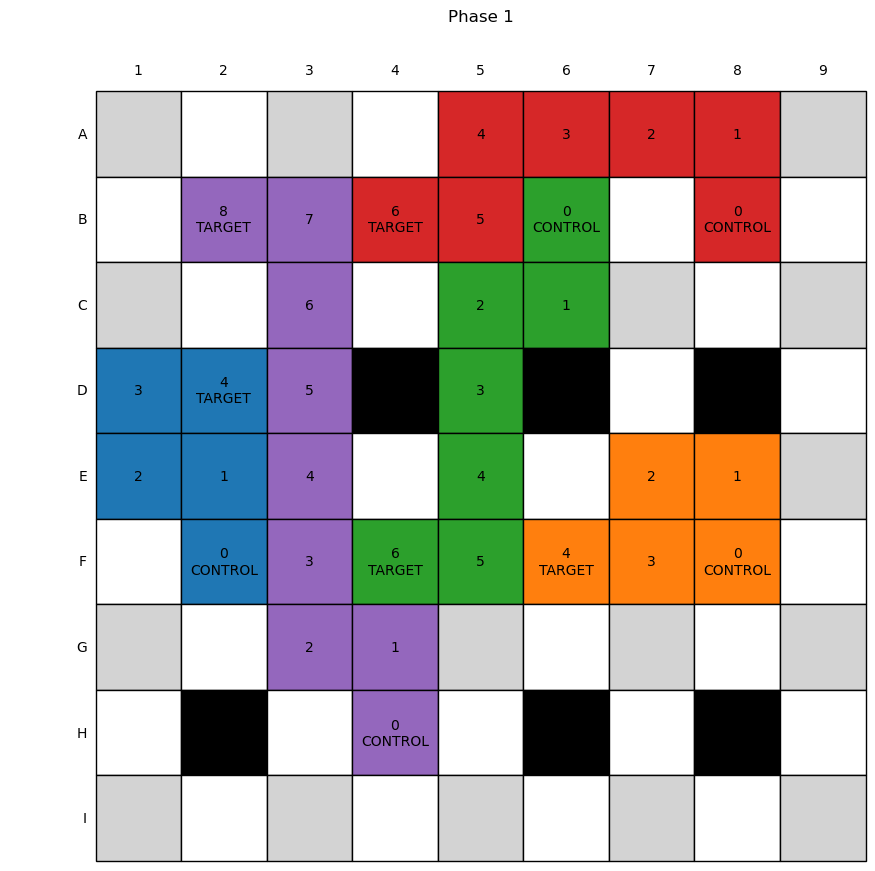

In [13]:
# Visualize the scheduling
Visualizer(grid_dims, scheduling).visualize()


### [Compilation](#compilation)

As a last step, the scheduling is compiled into a QIR program. This a fairly
complex step and there are still some issues with the compiler. But first, let's
have a look at what the compilers does at a high level.

```python
# Compile all the epochs in the scheduling
for epoch in self._scheduling:
    # Compile all the paths in the epoch
    for path in epoch:
        if path.get_type() == PathType.LONG_RANGE_CNOT:
            self._compile_long_range_cnot(path)
        elif path.get_type() == PathType.PHASE_1:
            self._compile_phase_1(path)
        else:  # path.get_type() == PathType.PHASE_2:
            self._compile_phase_2(path)
```

Depending on the type of the path, either a path which wasn't fragmented, a
fragment in phase 1 or a fragment in phase 2 different compilation routines are
called.

```python
# Compile a phase 1 path
def _compile_phase_1(self, path: Path) -> None:
    if is_data_qubit(path[0]):  # Control
        self._long_range_X_prep_with_ZZ_meas(path)
    elif is_data_qubit(path[-1]):  # Target
        self._long_range_Z_prep_with_XX_meas(path)
    else:
        self._long_range_bell_prep(path)

# Compile a phase 2 path
def _compile_phase_2(self, path: Path) -> None:
    if is_data_qubit(path[0]):  # Control
        self._long_range_teleport_with_ZZ_meas(path)
    elif is_data_qubit(path[-1]):  # Target
        self._long_range_teleport_with_XX_meas(path)
    else:
        self._long_range_bell_meas(path)
```

So there are seven different compilation routines which are briefly commented below.

![alt text](figures/long_range_cnot.png)\
_Long-range CNOT. [\[1\]](#references)_

This is the simplest case. It's a path from control to to target qubit. The Bell
preparation implemented below is used to prepare the Bell state to transport the
quantum states of both terminals near to each other. Note that by design, such
paths are at least 5 qubits long and have always an odd length.

![alt text](figures/comp_bell_prep.png)\
_Bell preparation. [\[1\]](#references)_

It's a path in phase 1 between to ancilla qubits. Note that by design, such
paths are at least 3 qubits long and have always an odd length.

![alt text](figures/comp_bell_meas.png)\
_Bell measurement. [\[1\]](#references)_

It's a path in phase 2 between to ancilla qubits. Note that by design, such
paths are at least 3 qubits long and have always an odd length.

![alt text](figures/long_range_x_prep_with_zz_meas.png)\
_Long-range X preparation with ZZ measurement. [\[1\]](#references)_

It's a path in phase 1 from the control to an ancilla qubit. Note that by
design, such paths are at least 2 qubits long and have always an even length.

![alt text](figures/long_range_z_prep_with_xx_meas.png)\
_Long-range Z preparation with XX measurement. [\[1\]](#references)_

It's a path in phase 1 from an ancilla to the target qubit. Note that by
design, such paths are at least 2 qubits long and have always an even length.

![alt text](figures/long_range_teleport_with_zz_meas.png)\
_Long-range teleportation with ZZ measurement. [\[1\]](#references)_

It's a path in phase 2 from the control to an ancilla qubit. Note that by
design, such paths are at least 2 qubits long and have always an even length.

![alt text](figures/long_range_teleport_with_xx_meas.png)\
_Long-range teleportation with XX measurement. [\[1\]](#references)_

It's a path in phase 2 from an ancilla to the target qubit. Note that by
design, such paths are at least 2 qubits long and have always an even length.

Like mentioned before, there are still some issues with the compiler. Both
teleportation routines are not correctly implemented! They
are by far the most complex routines because measurement results must be shared
between fragments of the same path. Further complexity is added to this issue
because I didn't find a way to compute the XOR on measurement results in PyQIR.
Without this, the teleportation routines seem to be impossible to implement
correctly.


In [14]:
# Compile the scheduled CNOTs into QIR
out_qir = Compiler(grid_dims, scheduling).compile()

# Write the output QIR
with open(os.path.join(root_dir, "qir/output.ll"), "wb") as f:
    f.write(out_qir.encode("utf-8"))
    f.flush()


## [Correctness](#correctness)

In order to check the correctness of the implementation of the compilation
scheme a sparse simulation tool called
[QIR-runner](https://github.com/qir-alliance/qir-runner) for QIR programs comes
in handy. The simulation is called _sparse_ because it only simulates the non-zero
components of the unitary.

As explained earlier, there are bugs in the teleportation routines. So the
simulation of the input QIR program and the final output QIR do not lead to the
same state vector!

Nonetheless, up to the compilation step, the implementation _seems_ to be
correct which is of course a weak argument. All the input circuits that I tested
lead to correct results.


In [15]:
ret = os.system("cd ../../qir-runner && cargo run ../qir/input.ll")
assert ret == 0


START
METADATA	EntryPoint
METADATA	requiredQubits	81
METADATA	requiredResults	81
STATE: [ |0⟩: 1+0i, ]
END	0


    Finished dev [unoptimized + debuginfo] target(s) in 0.13s
     Running `target/debug/qir-runner ../qir/input.ll`


In [16]:
ret = os.system("cd ../../qir-runner && cargo run ../qir/output.ll")
assert ret == 0


START
METADATA	EntryPoint
METADATA	requiredQubits	82
METADATA	requiredResults	86
Global Results: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
STATE: [ |0⟩: -0.17677669529663692+-0i, |1024⟩: -0.17677669529663692+-0i, |4096⟩: -0.17677669529663692+-0i, |5120⟩: -0.17677669529663692+-0i, |268435456⟩: -0.17677669529663692+-0i, |268436480⟩: -0.17677669529663692+-0i, |268439552⟩: -0.17677669529663692+-0i, |268440576⟩: -0.17677669529663692+-0i, |281474976710656⟩: -0.17677669529663692+-0i, |281474976711680⟩: -0.17677669529663692+-0i, |281474976714752⟩: -0.17677669529663692+-0i, |281474976715776⟩: -0.17677669529663692+-0i, |281475245146112⟩: -0.17677669529663692+-0i, |281475245147136⟩: -0.17677669529663692+-0i, |281475245150208⟩: -0.17677669529663692+-0i, |281475245151232⟩: -0.176776695

    Finished dev [unoptimized + debuginfo] target(s) in 0.04s
     Running `target/debug/qir-runner ../qir/output.ll`


## [Further steps](#further-steps)

For the program to be fully functional and correct, the teleportation routines
need to be debugged and fixed. Further, the delayed Pauli measurements need and
the phase gates (S and T) need to be implemented. Note that: $S = Z(\pi/2)$ and
$T = \sqrt{S} = Z(\pi/4)$.

![alt text](figures/rotations_using_cnot.png)\
_Rotations using CNOTs, which enable long-range rotations. [\[1\]](#references)_

Using this insight, one can implement the _long-range_ rotations using _long-range_ CNOTs.

![alt text](figures/algo_4_1.png)\
_Algorithm for rotations. [\[1\]](#references)_

The results can would look something like this:

![alt text](figures/transportation_of_rotations.png)\
_Results of the algorithm for rotations. [\[1\]](#references)_

Finally, when all is put together, the complete algorithm looks like this:

![alt text](figures/algo_5_1.png)\
_Complete algorithm. [\[1\]](#references)_

## [Further optimizations](#further-optimizations)

One can think of further optimizations steps, that are not discussed in the
paper. One interesting idea would be to compute a smarter mapping of qubits onto the grid,
which leads to shorter paths and fewer intersections. Further, one could
implement smarter routing algorithms, which try to minimize the number of
intersecting paths such the overall number of needed epochs is reduced. Finally,
it would be interesting to see if both approaches could be combined instead of just picking the
better one of the two.

## [Conclusion](#conclusion)

The authors of the paper show an impressive performance boost, meaning a
reduction on _logical space-time cost_ when using the novel technique. The
logical space-time cost is monotonically related to the _physical space-time cost_ which
is defined by the product of the number of qubits (circuit width) and the number
of logical time steps (circuit depth). Hence, minimizing the logical space-time cost is
equivalent to minimizing tje physical space-time cost.

![alt text](figures/performance.png)\
_Performance improvements. [\[1\]](#references)_

The technique I sketched out for you is fascinating, but it needs many qubits.
As new quantum chips with more and more qubits are being developed at an ever-increasing pace, I think the
in a _near future_, surface codes will be the basis of fault-tolerant large
scale quantum computing and, thus, compilation schemes and papers like this one are
extremely relevant and interesting to study right now! The project was great
fun!

## [Appendix](#appendix)

### [Operations](#operations)

In this section, all operations will be listed briefly for completeness with the
addition of some useful comments if any apply.

#### [Bell preparation](#bell-preparation)

![alt text](figures/bell_prep.png)\
_Bell preparation. [\[1\]](#references)_

Note that the first circuit can only be implemented horizontally, while the
second circuit can only be implemented vertically.

#### [Long-range Bell preparation](#long-range-bell-preparation)

![alt text](figures/long_range_bell_prep.png)\
_Long-range Bell preparation. [\[1\]](#references)_

#### [Bell measurement](#bell-measurement)

![alt text](figures/bell_meas.png)\
_Bell measurement. [\[1\]](#references)_

Note that the second circuit can only be implemented vertically, while the
third circuit can only be implemented horizontally. The first circuit can't be
implemented and is only theoretical.

#### [Hadamard](#hadamard)

![alt text](figures/hadamard.png)\
_Hadamard gate. [\[1\]](#references)_

The Hadamard gate is implemented at the lowest level of surface codes. Without
going into detail, the implementation involves moving a patch i.e. a logical
qubit around which explains the fact that the Hadamard gate actually needs a 2x2
grid of logical qubits.

#### [CNOT](#cnot)

![alt text](figures/cnot.png)\
_CNOT gate. [\[1\]](#references)_

#### [Long-range CNOT](#long-range-cnot)

![alt text](figures/long_range_cnot.png)\
_Long-range CNOT gate. [\[1\]](#references)_

#### [Move](#move)

![alt text](figures/move.png)\
_Move gate. [\[1\]](#references)_

Note that the first circuit can only be implemented vertically, while the
second circuit can only be implemented horizontally.

#### [Swap](#swap)

![alt text](figures/swap.png)\
_Swap gate. [\[1\]](#references)_

## [References](#references)

- [1] https://arxiv.org/pdf/2110.11493.pdf
- [2] https://doi.org/10.1007/s10107-002-0370-6
